# **AM 207**: Homework 2

Verena Kaynig-Fittkau and Pavlos Protopapas  <br>
**Due: 11.59 P.M. Thursday March 3rd, 2015**

### Instructions:

+ Upload your answers in an ipython notebook to Canvas.

+ We will provide you imports for your ipython notebook. Please do not import additional libraries.

+ Your individual submissions should use the following filenames: AM207_YOURNAME_HW2.ipynb

+ Your code should be in code cells as part of your ipython notebook. Do not use a different language (or format). 

+ **Do not just send your code. The homework solutions should be in a report style. Be sure to add comments to your code as well as markdown cells where you describe your approach and discuss your results. **

+ Please submit your notebook in an executed status, so that we can see all the results you computed. However, we will still run your code and all cells should reproduce the output when executed. 

+ If you have multiple files (e.g. you've added code files or images) create a tarball for all files in a single file and name it: AM207_YOURNAME_HW2.tar.gz or AM207_YOURNAME_HW2.zip


### Have Fun!
_ _ _ _ _

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")

import time
import timeit

import scipy.stats 
import pandas as pd
import pymc as pm

import re
import numpy as np

/Users/Grace/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Problem 1: Geweke Convergence Test

In the lecture we have seen the Geweke test as one option to test for convergence of our metropolis hastings chain. Describe in your own words how the Geweke test works and its limitations. 

We provide you with the following code for the Geweke test. Write comments for the marked lines and any lines you think would be good to explain in addition. 

Write a short explanation of what the `rhot` function does and why it is necessary. 

In [94]:
# calculate autocorrelation
def rhot(x, t):
    n = len(x)
    return np.corrcoef(x[0:(n-t)], x[t:n])[0,1]

# 
def Geweke(trace, intervals, length):
    nsl=length
    #
    jump = int(0.9*len(trace)/(2*intervals))
    #
    first = 0.1*len(trace)
    
    z =np.empty(intervals)
    #
    for k in np.arange(0, intervals):
        #
        baga = np.int(first+k*jump)
        #
        bagb = len(trace)/2 + k*jump
        
        #
        sub_trace_a = trace[baga:baga+nsl]
        sub_trace_b = trace[bagb:bagb+nsl]
        
        #
        theta_a = np.mean(sub_trace_a)
        theta_b = np.mean(sub_trace_b)
        rho_a, rho_b = 1.0, 1.0
        # 
        for i in xrange(int(0.1*nsl)):
            #
            rho_a += 2*rhot(sub_trace_a, i+1)
            rho_b += 2*rhot(sub_trace_b, i+1)
            
        # 
        var_a  = np.var(sub_trace_a)*rho_a/length
        var_b  = np.var(sub_trace_b)*rho_b/length
        
        #
        z[k] = (theta_a-theta_b)/np.sqrt( var_a + var_b)
    
    return z


In [7]:
np.arange(0, 20)
# np.random.choice
np.corrcoef?


# Problem 2: Message Response Times

The file `hangout_chat_data.csv` contains the response times of your friend Mark to google hangout chat messages in seconds. Use a method of your choice to read the file into a data frame or a numpy array. Your goal for this problem is to model Mark's chat response time distribution in a Bayesian framework. 

The description of the data sounds like a Poisson distribution is a good choice for our likelihood. We have messages arriving independently of each other, and instead of the arrival time we consider the time it took Mark to respond to the messages. 

* Load and describe the data by plotting a histogram of the response times. 
* Derive and compute the maximum likelihood solution for a Poisson distribution.
* Compare this to the Bayesian solution with a prior of your choice and using your own implementation of Metropolis Hastings to sample from the posterior. Make sure to describe why you chose this prior, as well as the specifics of your Metropolis Hastings implementation. 

* Analyze your sampling using traceplots and convergence tests. You can use the Geweke implementation given above. 
* Compare your solution to a solution using the MCMC class in pymc and write a brief discussion. Which parameters does your implementation need that the pymc implementation can do without? How do the traceplots compare? 

* Check your ML solution and the Bayesian solution against the data. If you know how you can use the posterior predictive for the Bayesian solution, otherwise you can use the MAP estimate or the expectation value of the posterior and compare that distribution to the data histogram. 

* Was our model a good choice for this problem? If yes great, if not, come up with a different Bayesian model that is better capable of capturing the data and show that it works better. 


## 1) Load and describe the data by plotting a histogram of the response times. 

In [19]:
import pandas as pd
df=pd.read_csv('hangout_chat_data.csv', delimiter='\r',header=None)
message_response_times = np.array(np.transpose(df.values)[0])
print message_response_times[:20]

[12 38 12 23 11 50 49 23 16  7 45 12  1  6 23 51 30 14 17 19]


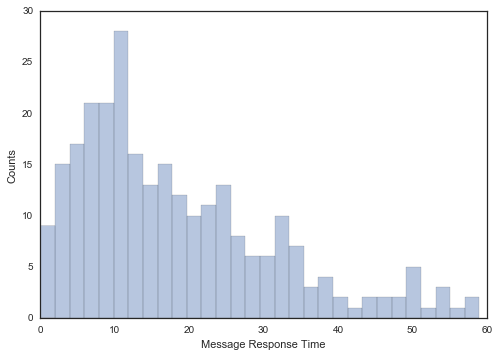

In [32]:
plt.hist(message_response_times, bins=30, alpha=0.4)
plt.xlabel('Message Response Time')
plt.ylabel('Counts')

## 2) Derive and compute the maximum likelihood solution for a Poisson distribution.

As stated in our problem, if the likelihood of our data ($x_{1}, x_{2}, \dots, x_{n}$) follows the Poisson distribution, then it can be written as follows : 
$$Likelihood = P(\bf{x}|\lambda) = e^{-\lambda}\frac{\lambda^{\bf{x}}}{\bf{x}!}$$
As each data is independent to each other, the formula above can be written as the product of each data point Likelihood.
$$P(\bf{x}|\lambda) = \prod_{n=1}^{N} P(x_{i}|\lambda) = e^{-\lambda}\frac{\lambda^{x_{i}}}{x_{i}!}$$
To estimate Maximum Likelihood, let's have log-likelihood.
$$Log Likelihood =\prod_{n=1}^{N} P(x_{i}|\lambda) = e^{-\lambda}\frac{\lambda^{x_{i}}}{x_{i}!}
= \sum_{n=1}^{N} \Big(-\lambda + x_{i}\ln\lambda - \ln(x_{i}!)\Big) = -N\lambda + \ln\lambda \sum_{n=1}^{N}x_{i}- \sum_{n=1}^{N}\ln(x_{i}!)\Big)$$
If we take derivative w.r.t $\lambda$,
$$\frac{\partial}{\partial \lambda}Log Likelihood = -N + \frac{\sum_{n=1}^{N}x_{i}}{\lambda} = 0$$
$$\therefore \lambda = \frac{1}{N}\sum_{n=1}^{N}x_{i}$$

Therefore, lambda from MLE solution is the same as mean value of our data set.

In [37]:
lambda_MLE = message_response_times.mean()
print "lambda_MLE :", lambda_MLE

lambda_MLE : 18.0413533835


## 3) Compare this to the Bayesian solution with a prior of your choice and using your own implementation of Metropolis Hastings to sample from the posterior. Make sure to describe why you chose this prior, as well as the specifics of your Metropolis Hastings implementation. 

* the reason why I chose the prior to be Normal distribution is that according to piazza, i read that 1) Use empirical Bayesian methods: this amounts to marginalizing out the parameter of inferential interest and treating the distribution of the data as a function of prior parameters (aka hyperparameters). Then standard techniques of inference, such as maximum likelihood, can be used to estimate the hyperparameters.

### 3-1. Define Prior, Likelihood and Posterior

In [44]:
len(message_response_times)

266

In [ ]:
## invLogit this is the same as a sigmoid
logitInv= lambda x: np.exp(x)/(1.0+np.exp(x))

## posterior
def calc_posterior(a, b, y=Y, x=X):
    # Calculate joint posterior, given values for a, b 
    # x: dosage
    # y: number of deaths
    # a + b: parameters of the model
    p = np.product((logitInv(a+b*x)**y)*(1.0-logitInv( a+b*x))**(n-y))
    
    return p

In [47]:
len(prior_problem2(message_response_times))
print likelihood_problem2([1,2], 1)

[ 0.36787944  0.18393972]


In [52]:
print np.product(np.array([1,2]))*np.array([10,11])

[20 22]


In [73]:
# ===============================================
# Define Prior : P(lambda)
# based on Normal distribution
# ===============================================
mean_prior_problem2 = lambda_MLE #18.04...
std_prior_problem2 = 10.0

prior_problem2 = lambda _lambda : scipy.stats.norm(mean_prior_problem2, std_prior_problem2).pdf(_lambda)


# ===============================================
# Define Likelihood : P(X | lambda)
# based on Poisson distribution
# ===============================================
likelihood_problem2 = lambda x, _lambda : scipy.stats.poisson.pmf(x, _lambda)


# ===============================================
# Define Posterior : P(lambda | X)
# ===============================================
def calc_posterior(_lambda):
    # since likelihood is product of xi, we need to sum them up
    # and likelihood is very small value, so we'll take log
    # since we only need to compare the value, not the exact value
#     print "likelihood : ", np.product(likelihood_problem2(message_response_times, _lambda))
#     print "prior : ", prior_problem2(_lambda)
    log_likelihood = np.log(likelihood_problem2(message_response_times, _lambda))
    sum_of_log_likelihood = np.sum(log_likelihood)
    log_prior = np.log(prior_problem2(_lambda))
    p =  sum_of_log_likelihood + log_prior
    return p

In [74]:
np.sum(np.log(scipy.stats.poisson.pmf(message_response_times[:10], 1)))

-605.89881895250426

In [165]:
rnorm = np.random.normal
runif = np.random.rand

def metropolis(n_iterations, initial_values, prop_std, doPrint=True):
    #################################################################
    # function to sample using Metropolis 
    # (assumes proposal distribution is symmetric)
    # 
    # n_iterations:  number of iterations
    # initial_values: multidimensional start position for our chain
    # prop_std: standard deviation for Gaussian proposal distribution 
    ##################################################################
    
    
    #np.random.seed(seed=1)
    n_params = len(initial_values)
            
    # Initial proposal standard deviations
    # generates a list of length n_params
    #prop_sd = [prop_std]*n_params
    prop_sd = prop_std
    
    # Initialize trace for parameters
    trace = np.empty((n_iterations+1, n_params))
    
    # Set initial values
    trace[0] = initial_values
        
    # Calculate joint posterior for initial values
    # the * assigns the arguments of the function according to the list elements
    current_prob = calc_posterior(*trace[0])
    global MAP_prob
    global MAP_lambda
    MAP_prob = current_prob
    MAP_lambda = initial_values
    
    # Initialize acceptance counts
    # We can use this to tune our step size
    accepted = [0]*n_params
    
    for i in range(n_iterations):
    
        if not i%10000 and doPrint: 
            print 'Iterations left: ', n_iterations-i
    
        # Grab current parameter values
        current_params = trace[i]
    
        # Get current value for parameter j
        p = trace[i].copy() 
        
        # loop over all dimensions
        for j in range(n_params):
            # proposed new value
            theta = rnorm(current_params[j], prop_sd[j])
            #print theta
            
            # Insert new value 
            p[j] = theta
    
            # Calculate posterior with proposed value
            proposed_prob = calc_posterior(*p)
    
            # Log-acceptance rate
            alpha = proposed_prob - current_prob
    
            # Sample a uniform random variate
            u = np.log(runif())
    
            # Test proposed value
            if (u) < alpha:
                # Accept
                trace[i+1,j] = theta
                current_prob = proposed_prob
                accepted[j] += 1
                if MAP_prob < proposed_prob:
                    MAP_lambda = theta
            else:
                # Stay put
                trace[i+1,j] = trace[i,j]
            
            # update p so we search the next dimension according
            # to the current result
            p[j] = trace[i+1,j]
    
    # return our samples and the number of accepted steps
    return trace, accepted

### Acceptance rate should be near 0.3

Let's look at the acceptance ratio to tune the stepsize Note that this most probably should be better done after the burn in, but I don't want the simulations to run for too long during the lecture

In [81]:
np.random.rand(1)*10

array([ 4.76157335])

[ 0.318]


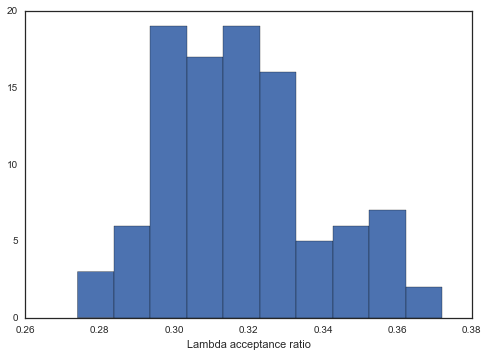

In [90]:
n_iter = 500
acc_ratios = []
for i in range(100):
    start_lambda = np.random.rand(1)*10
    trace, acc = metropolis(n_iter, (start_lambda), [1.0], doPrint=False)
    acc_ratios.append(acc/np.double(n_iter))

acc_ratios = np.array(acc_ratios)
plt.hist(acc_ratios[:,0])
plt.xlabel("Lambda acceptance ratio")
# plt.subplot(1,2,2)
# plt.hist(acc_ratios[:,1])
# plt.xlabel("beta acceptance ratio")

print np.mean(acc_ratios, axis=0)

### Now do sample from MH

In [93]:
n_iter = 100000
trace, acc = metropolis(n_iter, (start_lambda), [1.0])
print acc/np.double(n_iter)

Iterations left:  100000
Iterations left:  90000
Iterations left:  80000
Iterations left:  70000
Iterations left:  60000
Iterations left:  50000
Iterations left:  40000
Iterations left:  30000
Iterations left:  20000
Iterations left:  10000
[ 0.30461]


### Now see our Samples

In [95]:
burnin = 10000    # MY BURN IN 
# throw away the burnin samples
# alpha = trace[burnin:,0]; beta=trace[burnin:,1]
lambda_MH = trace[burnin:, 0]

In [179]:
# check my posterior. I do a brute force just to make sure I do the right thing
X1 = np.linspace(16,20,101) # alpha
j=0
pp=np.zeros(101)
for x1 in X1:
    pp[j]=calc_posterior(x1)
    j +=1

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

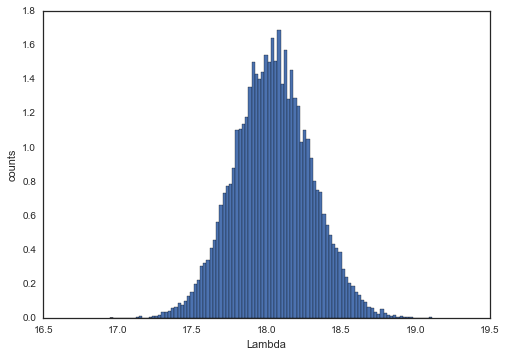

In [99]:
# histogram of alpha
# plt.subplot(2,1,1) 
fig=plt.hist(lambda_MH, bins=100, normed=True)
# xx= np.linspace(-3,7,101)
# pp_a = np.sum(pp, axis=1)
# plt.plot(xx, pp_a*6.0, 'r', label=u'True distribution') 
plt.legend()
plt.xlabel("Lambda")
plt.ylabel("counts")

# histogram of beta
# plt.subplot(2,1,2) 
# fig=plt.hist(beta, bins=100, normed=True)
# xx = np.linspace(-10, 30,100)
# pp_b = np.sum(pp, axis=0)
# plt.plot(xx, pp_b*1.5, 'r', label=u'True distribution') 
# plt.legend()
# plt.xlabel("beta")
# plt.ylabel("counts")

## 4) Analyze your sampling using traceplots and convergence tests. You can use the Geweke implementation given above. 

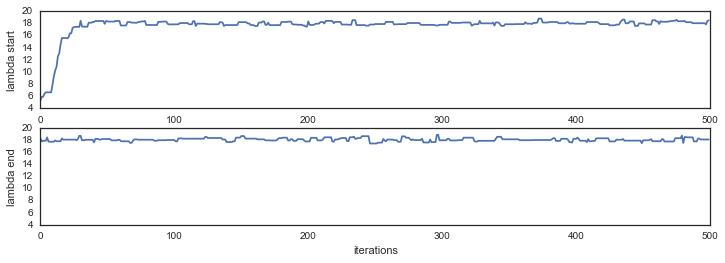

In [102]:
plt.figure(figsize=[12,8])

burnin = 500    # MY BURN IN 
# throw away the burnin samples
lambda_traceplot = trace[burnin:,0]

# trace plot for alpha during burnin
plt.subplot(4,1,1) 
plt.plot(trace[:burnin,0])
plt.ylim(4,20)
plt.xlabel("iterations")
plt.ylabel("lambda start")

# trace plot for alpha at the end 
# where we hopefully converged
plt.subplot(4,1,2) 
plt.plot(lambda_traceplot[-burnin:])
plt.ylim(4,20)
plt.xlabel("iterations")
plt.ylabel("lambda end")

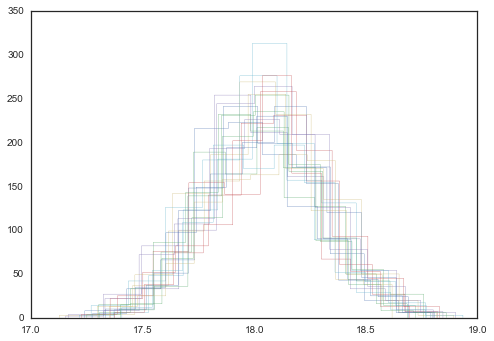

In [112]:
burnin = 25    # MY BURN IN 
# throw away the burnin samples
lambda_trace = trace[burnin:,0]

subsetSize = 1000
for i in range(20):
#     plt.hist(lambda_trace[subsetSize*i:subsetSize*(i+1)], alpha=0.4)
    plt.hist(lambda_trace[subsetSize*i:subsetSize*(i+1)], histtype="step")

Iterations left:  500
Iterations left:  500
Iterations left:  500
Iterations left:  500
Iterations left:  500
Iterations left:  500
Iterations left:  500
Iterations left:  500
Iterations left:  500
Iterations left:  500


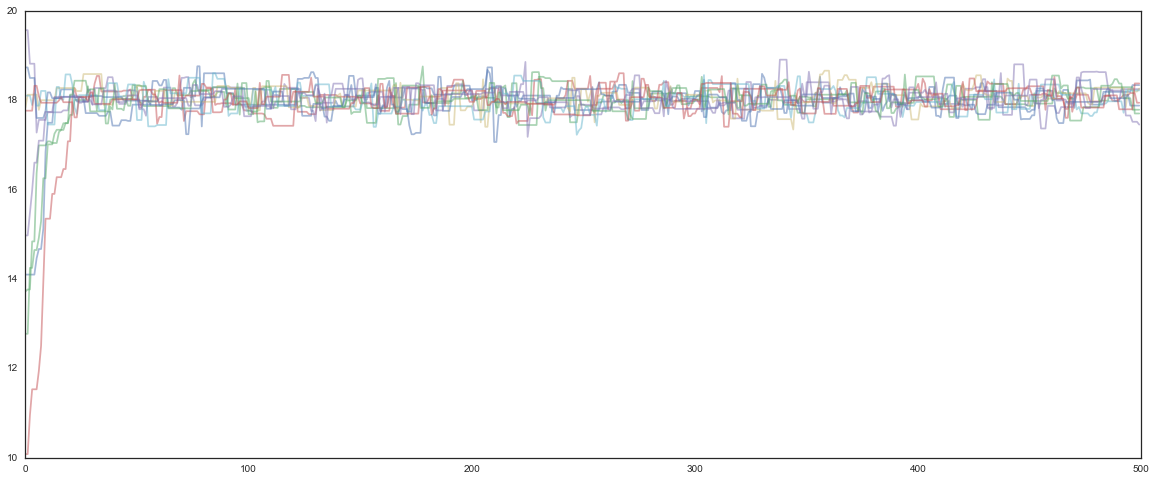

In [115]:
plt.figure(figsize=[20,8])

n_iter = 500
for i in range(10):
    start_lambda = np.random.rand(1)*10 + 10
    trace, acc = metropolis(n_iter, (start_lambda), [1.0])
    plt.plot(trace[-500:,0], alpha=0.5)

# Convergence test - Geweke

(90001,)


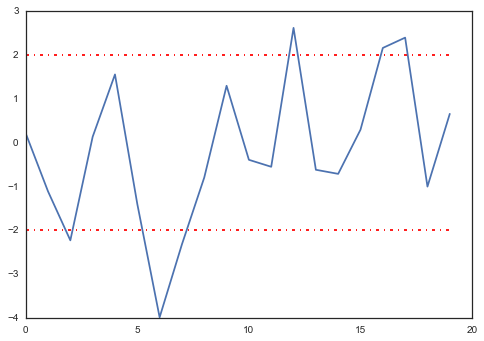

In [121]:
print lambda_MH.shape
z = Geweke(lambda_MH, intervals=20, length=200)

plt.plot( [2]*len(z), 'r-.')
plt.plot(z)
plt.plot( [-2]*len(z), 'r-.')
# geweke_scores = pm.geweke(trace[:,0], first =0.1, last=0.5, intervals=20)
# pm.Matplot.geweke_plot(geweke_scores, "alpha")

In [118]:
lambda_MH.shape

(90001,)

## 5) Compare your solution to a solution using the MCMC class in pymc and write a brief discussion. Which parameters does your implementation need that the pymc implementation can do without? How do the traceplots compare? 

Parameter that do without ? Proposal distribution (no need for standard deviation) + Acceptance rate calculation : uniform variable

In [128]:
?pm.Normal

In [146]:
lambda_pymc = pm.Normal('lamda', mu=lambda_MLE, tau=1.0) 
#beta = pm.Normal('beta', mu=0.0, tau=0.01)

# lambda_pymc = pm.Uniform("lambda", 0., 60.)
# beta = pm.Uniform("beta", -10., 40.)

# @pm.deterministic 
# def theta(a=alpha, b=beta, x=X):
#     return logitInv(a+b*x)

# deaths ~ binomial(n, p), 4 of them
# deaths = pm.Binomial('deaths', n=[5,5,5,5], p=theta, value=Y, observed=True)
# X ~ Poisson(lambda)
x_pymc = pm.Poisson('message_response_times', mu=lambda_pymc)

In [147]:
problem2_model = pm.Model([lambda_pymc, x_pymc])
mcmc = pm.MCMC(problem2_model)
mcmc.sample(iter=100000, burn=0)

 [-----------------100%-----------------] 100000 of 100000 complete in 5.5 sec

In [ ]:
bioassay_model=pm.Model([alpha, beta, theta, deaths])
mcmc = pm.MCMC(bioassay_model)
mcmc.sample(iter=100000, burn=0)

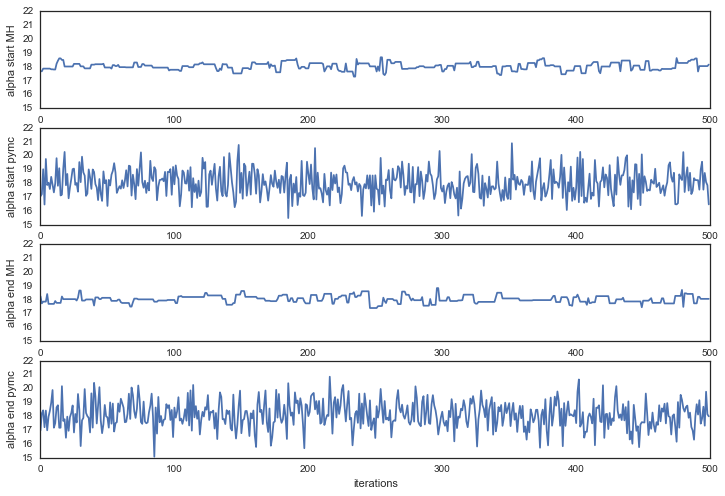

In [150]:
plt.figure(figsize=[12,8])

burnin = 500

# trace plot for alpha from our MH implementation
plt.subplot(4,1,1) 
plt.plot(lambda_MH[:burnin])
plt.ylim(15,22)
plt.xlabel("iterations")
plt.ylabel("alpha start MH")

# trace plot for alpha from pymc
plt.subplot(4,1,2) 
plt.plot(lambda_pymc.trace()[:burnin])
plt.ylim(15,22)
plt.xlabel("iterations")
plt.ylabel("alpha start pymc")

# trace plot for alpha from our MH implementation
plt.subplot(4,1,3) 
plt.plot(lambda_MH[-burnin:])
plt.ylim(15,22)
plt.xlabel("iterations")
plt.ylabel("alpha end MH")

# trace plot for alpha from pymc
plt.subplot(4,1,4) 
plt.plot(lambda_pymc.trace()[-burnin:])
plt.ylim(15,22)
plt.xlabel("iterations")
plt.ylabel("alpha end pymc")

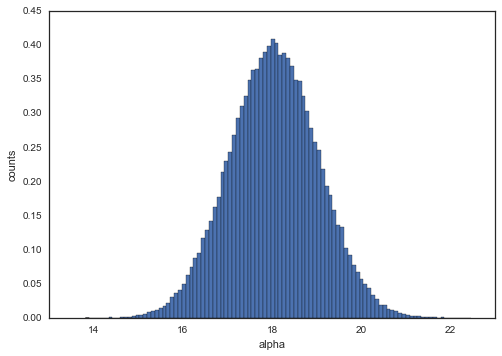

In [149]:
# histogram of alpha
fig=plt.hist(lambda_pymc.trace(), bins=100, normed=True)
# xx= np.linspace(-3,7,101)
# pp_a = np.sum(pp, axis=1)
# plt.plot(xx, pp_a*6.0, 'r', label=u'True distribution') 
plt.legend()
plt.xlabel("alpha")
plt.ylabel("counts")

Plotting lamda


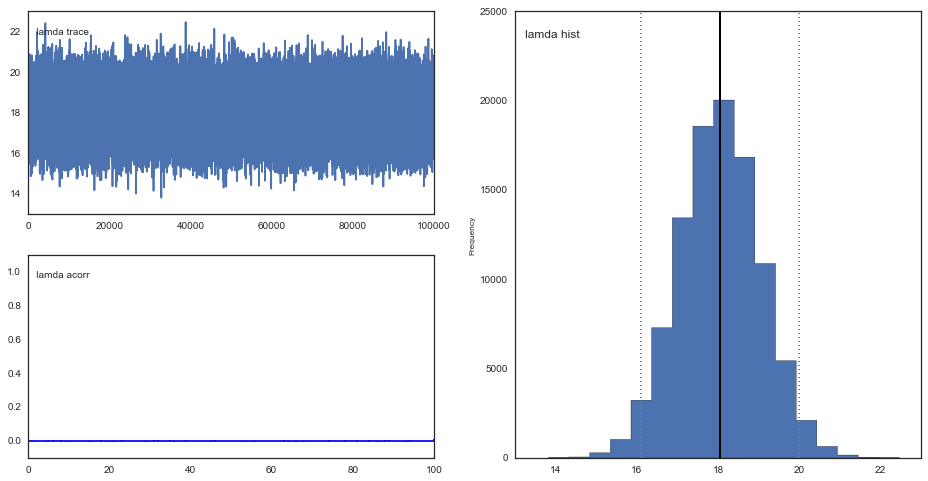

In [151]:
fig = plt.figure(figsize=(16,8))
pm.Matplot.plot(lambda_pymc, new=False)

In [152]:
mcmc.summary()


message_response_times:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	18.035           4.351            0.013                [ 10.  26.]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	10.0             15.0            18.0           21.0          27.0
	

lamda:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	18.042           0.994            0.003          [ 16.095  19.985]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	16.102           17.37           18.042         18.714        19.993
	


In [153]:
mcmc.stats()

{'lamda': {'95% HPD interval': array([ 16.09546195,  19.98516264]),
  'mc error': 0.0031367189655330738,
  'mean': 18.04239586981441,
  'n': 100000,
  'quantiles': {2.5: 16.102345095660045,
   25: 17.370334858981309,
   50: 18.042234003786628,
   75: 18.713618056795546,
   97.5: 19.993383634312707},
  'standard deviation': 0.99446305190837259},
 'message_response_times': {'95% HPD interval': array([ 10.,  26.]),
  'mc error': 0.012729604235796161,
  'mean': 18.035240000000002,
  'n': 100000,
  'quantiles': {2.5: 10.0, 25: 15.0, 50: 18.0, 75: 21.0, 97.5: 27.0},
  'standard deviation': 4.3514271385833876}}

## 6) Check your ML solution and the Bayesian solution against the data. If you know how you can use the posterior predictive for the Bayesian solution, otherwise you can use the MAP estimate or the expectation value of the posterior and compare that distribution to the data histogram. 

In [155]:
MAP_prob = 0
MAP_lambda = 0

In [166]:
n_iter = 100000
trace, acc = metropolis(n_iter, (start_lambda), [1.0])
print acc/np.double(n_iter)

Iterations left:  100000
Iterations left:  90000
Iterations left:  80000
Iterations left:  70000
Iterations left:  60000
Iterations left:  50000
Iterations left:  40000
Iterations left:  30000
Iterations left:  20000
Iterations left:  10000
[ 0.30532]


In [167]:
burnin = 10000    # MY BURN IN 
# throw away the burnin samples
# alpha = trace[burnin:,0]; beta=trace[burnin:,1]
lambda_MH = trace[burnin:, 0]

In [169]:
print "log of MAP probability :", MAP_prob
print "lambda at MAP :", MAP_lambda

log of MAP probability : -1945.13599158
lambda at MAP : 18.0605762199


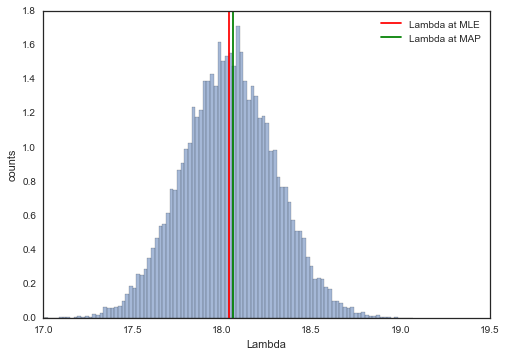

In [185]:
# histogram of alpha
# plt.subplot(2,1,1) 
fig=plt.hist(lambda_MH, bins=100, normed=True, alpha=0.5)
# xx= np.linspace(-3,7,101)
# plt.plot( [2]*len(z), 'r-.')
# pp_a = np.sum(pp, axis=1)
# plt.plot(xx, pp_a*6.0, 'r', label=u'True distribution') 
plt.axvline(x=lambda_MLE, color='r', label='Lambda at MLE')
plt.axvline(x=MAP_lambda, color='g', label='Lambda at MAP')
plt.legend()
plt.xlabel("Lambda")
plt.ylabel("counts")

# histogram of beta
# plt.subplot(2,1,2) 
# fig=plt.hist(beta, bins=100, normed=True)
# xx = np.linspace(-10, 30,100)
# pp_b = np.sum(pp, axis=0)
# plt.plot(xx, pp_b*1.5, 'r', label=u'True distribution') 
# plt.legend()
# plt.xlabel("beta")
# plt.ylabel("counts")

## 7) Was our model a good choice for this problem? If yes great, if not, come up with a different Bayesian model that is better capable of capturing the data and show that it works better. 


# Problem 3: Markov Chains

* Given the following transition matrix, examine if the corresponding Markov Chain is irreducible and aperiodic. Note: No formal proof necessary, but you should give a solid argumentation.

$$ P = \left( 
\begin{array}{ccccc}
0.0 & 0.4 & 0.6 & 0.0 & 0.0 \\
0.65 & 0.0 & 0.35 & 0.0 & 0.0 \\
0.32 & 0.68 & 0.0 & 0.0 & 0.0 \\
0.0 & 0.0 & 0.0 & 0.12 & 0.88 \\
0.0 & 0.0 & 0.0 & 0.56 & 0.44 
\end{array}
\right ) $$



# Problem 4: The Evidence 

In lectures we mostly concentrate on the likelihood and the prior and regard the evidence as a mere normalization factor. However, the evidence can be quite useful. In this problem you will compare different models by computing the evidence for each model, aka the probability that randomly selected parameters from a given model class would generate the data $X$.

As our models we compare polynomials of degree 0 to 4. For example for degree 2 we have $y = a_0 + a_1 \cdot x + a_2 \cdot x^2 + \epsilon$ where $\epsilon \sim N(0, \sigma) $ and $\theta = [a_0, a_1, a_2, \sigma]$. Assume that for all polynomials $a_i \sim \text{Expo}(1)$ and $\sigma \sim \text{Inverse Gamma}(1,1)$.


Bayes' theorem states that:
$$
P(\theta|x)=\frac{P(x|\theta)P(\theta)}{P(x)}
$$
$P(\theta)$ is the prior, $P(x|\theta)$ is the likelihood, $P(x)$ is called the evidence, and $P(\theta|x)$ is the posterior.

Your tasks are:

* Write down the mathematical equation of the evidence in terms of the likelihood and the prior. You don't need to solve the integral analytically, just write down its formula.
* Now you have the evidence in the form of an integral. Solve it by using importance sampling. What is a good choice for your importance sampling distribution?
* Compare the evidence for polynomials of degree 0 to 4. Which polynomial wins?

In [186]:
# Here is your data for the problem:
data = np.array([[ -1.85519254,  -2.7009541 ],
       [  4.38291824,  19.61735369],
       [  2.29495208,   3.96481822],
       [  0.02075668,   8.00646088],
       [  0.54097177,   2.8872262 ]])

x=data[:,0]
y=data[:,1]

## 1) Write down the mathematical equation of the evidence in terms of the likelihood and the prior. You don't need to solve the integral analytically, just write down its formula.

$$
Evidence = P(x)=\int_{\theta}\underbrace{P(x|\theta)}_\text{likelihood}\underbrace{P(\theta)}_\text{prior}d\theta
$$

## 2) Now you have the evidence in the form of an integral. Solve it by using importance sampling. What is a good choice for your importance sampling distribution?

The good choice for our importance sampling distribution would be the same distribution with our prior.

Let's say we define our function as follows : 
* $f(\theta) = P(x|\theta)P(\theta)$
* $g(\theta) = P(\theta) = prior$

Then our integral can be changed as :
$$
Evidence = P(x)=\int_{\theta}\underbrace{P(x|\theta)}_\text{likelihood}\underbrace{P(\theta)}_\text{prior}d\theta = \int_{\theta}f(\theta)d\theta = \int_{\theta}\frac{f(\theta)}{g(\theta)}g(\theta)d\theta = E_{Q}\Big[\frac{f(\theta)}{g(\theta)}\Big] = \sum \frac{f(\theta)}{g(\theta)}
$$

So if we assume our choice of importance sampling distribution to be the same as prior, then
$$
\frac{f(\theta)}{g(\theta)} = P(y|\theta) = P(a_0 + a_1 \cdot x + a_2 \cdot x^2 + \epsilon |a_0, a_1, a_2, \epsilon)
$$

And this would follow Normal distribution since each parameter in $\theta$ is given.
$$
P(y|\theta) = N(a_0 + a_1 \cdot x + a_2 \cdot x^2 + \epsilon, \sigma)
$$

Now, let's solve this integral using importance sampling

### Degree 0

In [213]:
mu_function0 = lambda a0, e: a0 + e

p = lambda y, sig, mu: (1/np.sqrt(2*np.pi*sig**2))*np.exp(-(y-mu)**2/(2.0*sig**2))

# Number of draws 
N = 1000


# ============================================
# IMPORTANCE SAMPLING 
# ============================================
Iis = np.zeros(1000)
for k in np.arange(0,1000):
    p_for_each_xy = np.zeros(len(x))
    for i in range(len(x)):
        # draw paramters
        a0 = np.random.exponential(scale=1.0, size=N)

        sig = scipy.stats.invgamma.rvs(a=1.0, size=N)
        e = 0 + sig*np.random.normal(size=N)
        mu = mu_function0(a0, e)

        # computing our estimates
        p_for_each_xy[i] = np.mean(p(y[i], sig, mu))
    
    Iis[k] = np.mean(p_for_each_xy)

print "Mean importance sampling MC estimate: ", np.mean(Iis)
print "Standard deviation of our estimates: ", np.std(Iis)

Mean importance sampling MC estimate:  0.033263912307
Standard deviation of our estimates:  0.00104132998392


### Degree 1

In [214]:
mu_function1 = lambda a0, a1, e, x: a0 + a1*x + e

p = lambda y, sig, mu: (1/np.sqrt(2*np.pi*sig**2))*np.exp(-(y-mu)**2/(2.0*sig**2))

# Number of draws 
N = 1000


# ============================================
# IMPORTANCE SAMPLING 
# ============================================
Iis = np.zeros(1000)
for k in np.arange(0,1000):
    p_for_each_xy = np.zeros(len(x))
    for i in range(len(x)):
        # draw paramters
        a0 = np.random.exponential(scale=1.0, size=N)
        a1 = np.random.exponential(scale=1.0, size=N)

        sig = scipy.stats.invgamma.rvs(a=1.0, size=N)
        e = 0 + sig*np.random.normal(size=N)
        mu = mu_function1(a0, a1, e, x[i])

        # computing our estimates
        p_for_each_xy[i] = np.mean(p(y[i], sig, mu))
    
    Iis[k] = np.mean(p_for_each_xy)

print "Mean importance sampling MC estimate: ", np.mean(Iis)
print "Standard deviation of our estimates: ", np.std(Iis)

Mean importance sampling MC estimate:  0.0596261015068
Standard deviation of our estimates:  0.00169469251934


### Degree 2

In [209]:
mu_function2 = lambda a0, a1, a2, e, x: a0 + a1*x + a2*(x**2) + e

p = lambda y, sig, mu: (1/np.sqrt(2*np.pi*sig**2))*np.exp(-(y-mu)**2/(2.0*sig**2))

# Number of draws 
N = 1000


# ============================================
# IMPORTANCE SAMPLING 
# ============================================
Iis = np.zeros(1000)
for k in np.arange(0,1000):
    p_for_each_xy = np.zeros(len(x))
    for i in range(len(x)):
        # draw paramters
        a0 = np.random.exponential(scale=1.0, size=N)
        a1 = np.random.exponential(scale=1.0, size=N)
        a2 = np.random.exponential(scale=1.0, size=N)

        sig = scipy.stats.invgamma.rvs(a=1.0, size=N)
        e = 0 + sig*np.random.normal(size=N)
        mu = mu_function2(a0, a1, a2, e, x[i])

        # computing our estimates
        p_for_each_xy[i] = np.mean(p(y[i], sig, mu))
    
    Iis[k] = np.mean(p_for_each_xy)

print "Mean importance sampling MC estimate: ", np.mean(Iis)
print "Standard deviation of our estimates: ", np.std(Iis)

Mean importance sampling MC estimate:  0.0518374164631
Standard deviation of our estimates:  0.00163657610052



### Degree 3

In [215]:
mu_function3 = lambda a0, a1, a2, a3, e, x: a0 + a1*x + a2*(x**2) + a3*(x**3) + e

p = lambda y, sig, mu: (1/np.sqrt(2*np.pi*sig**2))*np.exp(-(y-mu)**2/(2.0*sig**2))

# Number of draws 
N = 1000


# ============================================
# IMPORTANCE SAMPLING 
# ============================================
Iis = np.zeros(1000)
for k in np.arange(0,1000):
    p_for_each_xy = np.zeros(len(x))
    for i in range(len(x)):
        # draw paramters
        a0 = np.random.exponential(scale=1.0, size=N)
        a1 = np.random.exponential(scale=1.0, size=N)
        a2 = np.random.exponential(scale=1.0, size=N)
        a3 = np.random.exponential(scale=1.0, size=N)

        sig = scipy.stats.invgamma.rvs(a=1.0, size=N)
        e = 0 + sig*np.random.normal(size=N)
        mu = mu_function3(a0, a1, a2, a3, e, x[i])

        # computing our estimates
        p_for_each_xy[i] = np.mean(p(y[i], sig, mu))
    
    Iis[k] = np.mean(p_for_each_xy)

print "Mean importance sampling MC estimate: ", np.mean(Iis)
print "Standard deviation of our estimates: ", np.std(Iis)

Mean importance sampling MC estimate:  0.0434371924225
Standard deviation of our estimates:  0.00145700150131


### Degree 4

In [217]:
mu_function4 = lambda a0, a1, a2, a3, a4, e, x: a0 + a1*x + a2*(x**2) + a3*(x**3) + a4*(x**4) + e

p = lambda y, sig, mu: (1/np.sqrt(2*np.pi*sig**2))*np.exp(-(y-mu)**2/(2.0*sig**2))

# Number of draws 
N = 1000


# ============================================
# IMPORTANCE SAMPLING 
# ============================================
Iis = np.zeros(1000)
for k in np.arange(0,1000):
    p_for_each_xy = np.zeros(len(x))
    for i in range(len(x)):
        # draw paramters
        a0 = np.random.exponential(scale=1.0, size=N)
        a1 = np.random.exponential(scale=1.0, size=N)
        a2 = np.random.exponential(scale=1.0, size=N)
        a3 = np.random.exponential(scale=1.0, size=N)
        a4 = np.random.exponential(scale=1.0, size=N)

        sig = scipy.stats.invgamma.rvs(a=1.0, size=N)
        e = 0 + sig*np.random.normal(size=N)
        mu = mu_function4(a0, a1, a2, a3, a4, e, x[i])

        # computing our estimates
        p_for_each_xy[i] = np.mean(p(y[i], sig, mu))
    
    Iis[k] = np.mean(p_for_each_xy)

print "Mean importance sampling MC estimate: ", np.mean(Iis)
print "Standard deviation of our estimates: ", np.std(Iis)

Mean importance sampling MC estimate:  0.0344202772945
Standard deviation of our estimates:  0.00127212866944


## 3) Compare the evidence for polynomials of degree 0 to 4. Which polynomial wins?

| Left align | Right align | Center align |
|:-----------|------------:|:------------:|
| This       |        This |     This     
| column     |      column |    column    
| will       |        will |     will     
| be         |          be |      be      
| left       |       right |    center    
| aligned    |     aligned |   aligned

# Problem 5: Which YouTube Videos to Watch

Youtube videos have a like and an unlike flag. We can use these up and down votes on the videos to determine if a video is worth watching. However, it is not immediately obvious how to rank a video with just 3 up and 0 down rankings against a video with 300 up and 100 down votes. We will address this problem using a Bayesian approach.

Build two Bayesian models for the average upvote rate of a video. Both models should use the same likelihood, but different priors. Use one prior where people in general are rather undecided about videos, and one where people tend to be very opinionated. Compare the resulting posteriors for each video. How does the different choice of prior change your results? 

Given that there are so many videos on YouTube we want a really conservative way to decide if it is worth watching. Compute the 5th percentile for the posterior of each video and rank the videos according to this value. Is the 5th percentile a good indicator for the ranking? What are the benefits, what are potential drawbacks?

In [13]:
# Here is the [upvote, downvote] data for 4 different videos:
video_votes = np.array([[3,0],[300,100],[2,2],[200,100]])